In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

# -------------------------------
# Step 1: Load and Clean Data
# -------------------------------

# Load CSV file
file_path = 'merge-csv.com__685e341ae0fa0.csv'
df = pd.read_csv(file_path, header=None)

# Assign column names
columns = ['Date'] + [f'Hour_{i}' for i in range(1, 25)]
df.columns = columns

# Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.dropna(subset=['Date']).reset_index(drop=True)

# Melt to long format
df_long = df.melt(id_vars='Date', var_name='Hour', value_name='Demand')
df_long['Hour'] = df_long['Hour'].str.replace('Hour_', '').astype(int)
df_long['DateTime'] = pd.to_datetime(df_long['Date']) + pd.to_timedelta(df_long['Hour'], unit='h')
df_long.set_index('DateTime', inplace=True)
df_long = df_long[['Demand']].sort_index()

# Convert to numeric and interpolate missing values
df_long['Demand'] = pd.to_numeric(df_long['Demand'], errors='coerce')
df_long = df_long.interpolate(method='time')

# Resample to daily average demand
df_daily = df_long.resample('D').mean()

# -------------------------------
# Step 2: Feature Engineering
# -------------------------------

def create_features(data):
    data = data.copy()
    data['DayOfWeek'] = data.index.dayofweek
    data['Month'] = data.index.month
    data['WeekOfYear'] = data.index.isocalendar().week.astype(int)
    data['IsWeekend'] = (data['DayOfWeek'] >= 5).astype(int)
    return data

# Add lagged features
def add_lags(data, lags=7):
    df_ = data.copy()
    for lag in range(1, lags+1):
        df_[f'Demand_Lag_{lag}'] = df_['Demand'].shift(lag)
    df_.dropna(inplace=True)
    return df_

# Create full feature set
df_featured = create_features(df_daily)
df_featured = add_lags(df_featured, lags=7)

# Define input features and target
X = df_featured.drop(columns=['Demand'])
y = df_featured['Demand']

# Split training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate model
test_preds = model.predict(X_test)
mape = mean_absolute_percentage_error(y_test, test_preds) * 100
print(f"Model MAPE on test data: {mape:.2f}%")

# -------------------------------
# Step 3: Forecast 2023 Daily Demand
# -------------------------------

# Generate date range for 2023
future_dates = pd.date_range(start='2023-01-01', end='2023-12-31', freq='D')

# Start with last known row from historical data
current_data = X.iloc[-1].copy()
predictions = []

for date in future_dates:
    # Ensure current_data has same number of features as training data
    if len(current_data) != X_train.shape[1]:
        raise ValueError(f"Mismatch in feature count: expected {X_train.shape[1]}, got {len(current_data)}")

    # Reshape and predict
    X_input = current_data.values.reshape(1, -1)
    pred = model.predict(X_input)[0]

    # Append prediction
    predictions.append(pred)

    # Shift lagged values
    for lag in range(1, 8):
        if lag == 1:
            current_data[f'Demand_Lag_{lag}'] = pred
        else:
            # Use previous lag or fallback to most recent available demand
            if len(predictions) >= lag:
                current_data[f'Demand_Lag_{lag}'] = predictions[-lag]
            else:
                # If not enough history, keep repeating the latest prediction
                current_data[f'Demand_Lag_{lag}'] = pred

    # Update index
    current_data.name = date

# -------------------------------
# Step 4: Save Predictions to CSV
# -------------------------------

pred_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Demand': predictions
})

pred_df.to_csv('predicted_demand_2023.csv', index=False)
print("✅ Predictions saved to 'predicted_demand_2023.csv'")

Model MAPE on test data: 3.33%


c:\Users\Sanjeev\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\Sanjeev\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\Sanjeev\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\Sanjeev\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\Sanjeev\AppData\Local\Programs\Python\Python310\lib\site-packag

✅ Predictions saved to 'predicted_demand_2023.csv'


c:\Users\Sanjeev\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\Sanjeev\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\Sanjeev\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\Sanjeev\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\Sanjeev\AppData\Local\Programs\Python\Python310\lib\site-packag

In [3]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

# -------------------------------
# Step 1: Load and Clean Data
# -------------------------------

file_path = 'merge-csv.com__685e341ae0fa0.csv'
df = pd.read_csv(file_path, header=None)

# Assign column names
columns = ['Date'] + [f'Hour_{i}' for i in range(1, 25)]
df.columns = columns

# Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.dropna(subset=['Date']).reset_index(drop=True)

# Melt to long format
df_long = df.melt(id_vars='Date', var_name='Hour', value_name='Demand')
df_long['Hour'] = df_long['Hour'].str.replace('Hour_', '').astype(int)
df_long['DateTime'] = df_long['Date'] + pd.to_timedelta(df_long['Hour'], unit='h')
df_long.set_index('DateTime', inplace=True)
df_long = df_long[['Demand']].sort_index()

# Convert to numeric and interpolate missing values
df_long['Demand'] = pd.to_numeric(df_long['Demand'], errors='coerce')
df_long = df_long.interpolate(method='time')

# -------------------------------
# Step 2: Feature Engineering
# -------------------------------

def create_features(data):
    data = data.copy()
    data['DayOfWeek'] = data.index.dayofweek
    data['Month'] = data.index.month
    data['WeekOfYear'] = data.index.isocalendar().week.astype(int)
    data['HourOfDay'] = data.index.hour
    data['IsWeekend'] = (data['DayOfWeek'] >= 5).astype(int)
    return data

# Add lagged features (past 24 hours)
def add_lags(data, lags=24):
    df_ = data.copy()
    for lag in range(1, lags+1):
        df_[f'Demand_Lag_{lag}'] = df_['Demand'].shift(lag)
    df_.dropna(inplace=True)
    return df_

# Create feature set
df_featured = create_features(df_long)
df_featured = add_lags(df_featured, lags=24)

# Define input and target
X = df_featured.drop(columns=['Demand'])
y = df_featured['Demand']

# Split training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate model
test_preds = model.predict(X_test)
mape = mean_absolute_percentage_error(y_test, test_preds) * 100
print(f"Model MAPE on test data: {mape:.2f}%")

# -------------------------------
# Step 3: Forecast 2023 Hourly Demand
# -------------------------------

# Generate date range for 2023
future_dates = pd.date_range(start='2023-01-01', end='2023-12-31 23:00', freq='H')

# Start with last known row from historical data
current_data = X.iloc[-1].copy()
predictions = []

for date in future_dates:
    # Ensure current_data has same number of features as training data
    if len(current_data) != X_train.shape[1]:
        raise ValueError(f"Mismatch in feature count: expected {X_train.shape[1]}, got {len(current_data)}")

    # Reshape and predict
    X_input = current_data.values.reshape(1, -1)
    pred = model.predict(X_input)[0]
    predictions.append(pred)

    # Shift lagged values
    for lag in range(1, 25):  # Update 24 lagged features
        if lag == 1:
            current_data[f'Demand_Lag_{lag}'] = pred
        else:
            current_data[f'Demand_Lag_{lag}'] = df_featured[f'Demand_Lag_{lag - 1}'].iloc[-1] if lag > 1 else pred

# -------------------------------
# Step 4: Save Predictions to CSV
# -------------------------------

pred_df = pd.DataFrame({
    'DateTime': future_dates,
    'Predicted_Demand': predictions
})

pred_df.to_csv('predicted_hourly_demand_2023.csv', index=False)
print("✅ Hourly predictions saved to 'predicted_hourly_demand_2023.csv'")

Model MAPE on test data: 2.55%


C:\Users\Sanjeev\AppData\Local\Temp\ipykernel_256\1220286993.py:79: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_dates = pd.date_range(start='2023-01-01', end='2023-12-31 23:00', freq='H')
c:\Users\Sanjeev\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\Sanjeev\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\Sanjeev\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\Sanjeev\AppData\Local\Programs\Python\Python

✅ Hourly predictions saved to 'predicted_hourly_demand_2023.csv'


c:\Users\Sanjeev\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\Sanjeev\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\Sanjeev\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\Sanjeev\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\Sanjeev\AppData\Local\Programs\Python\Python310\lib\site-packag

In [4]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

# -------------------------------
# Step 1: Load and Clean Data
# -------------------------------

# Load CSV file
file_path = 'merge-csv.com__685e341ae0fa0.csv'
df = pd.read_csv(file_path, header=None)

# Assign column names
columns = ['Date'] + [f'Hour_{i}' for i in range(1, 25)]
df.columns = columns

# Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.dropna(subset=['Date']).reset_index(drop=True)

# Melt to long format
df_long = df.melt(id_vars='Date', var_name='Hour', value_name='Demand')
df_long['Hour'] = df_long['Hour'].str.replace('Hour_', '').astype(int)
df_long['DateTime'] = df_long['Date'] + pd.to_timedelta(df_long['Hour'], unit='h')
df_long.set_index('DateTime', inplace=True)
df_long = df_long[['Demand']].sort_index()

# Convert to numeric and interpolate missing values
df_long['Demand'] = pd.to_numeric(df_long['Demand'], errors='coerce')
df_long = df_long.interpolate(method='time')

# -------------------------------
# Step 2: Feature Engineering
# -------------------------------

def create_features(data):
    data = data.copy()
    data['DayOfWeek'] = data.index.dayofweek
    data['Month'] = data.index.month
    data['WeekOfYear'] = data.index.isocalendar().week.astype(int)
    data['HourOfDay'] = data.index.hour
    data['IsWeekend'] = (data['DayOfWeek'] >= 5).astype(int)
    return data

# Add lagged features (past 24 hours)
def add_lags(data, lags=24):
    df_ = data.copy()
    for lag in range(1, lags+1):
        df_[f'Demand_Lag_{lag}'] = df_['Demand'].shift(lag)
    df_.dropna(inplace=True)
    return df_

# Create full feature set
df_featured = create_features(df_long)
df_featured = add_lags(df_featured, lags=24)

# Define input and target
X = df_featured.drop(columns=['Demand'])
y = df_featured['Demand']

# Split training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate model
test_preds = model.predict(X_test)
mape = mean_absolute_percentage_error(y_test, test_preds) * 100
print(f"Model MAPE on test data: {mape:.2f}%")

# -------------------------------
# Step 3: Forecast 2023 Hourly Demand
# -------------------------------

# Generate date range for 2023 (all 8760 hours)
future_dates = pd.date_range(start='2023-01-01', end='2023-12-31 23:00', freq='H')

# Start with last known row from historical data
current_data = X.iloc[-1].copy()
predictions = []

for date in future_dates:
    # Ensure current_data has same number of features as training data
    if len(current_data) != X_train.shape[1]:
        raise ValueError(f"Mismatch in feature count: expected {X_train.shape[1]}, got {len(current_data)}")

    # Reshape and predict
    X_input = current_data.values.reshape(1, -1)
    pred = model.predict(X_input)[0]
    predictions.append(pred)

    # Update lagged features
    for lag in range(24, 0, -1):  # From 24 to 1
        if lag == 1:
            current_data[f'Demand_Lag_{lag}'] = pred
        else:
            current_data[f'Demand_Lag_{lag}'] = current_data[f'Demand_Lag_{lag - 1}']

# -------------------------------
# Step 4: Save Predictions to CSV
# -------------------------------

pred_df = pd.DataFrame({
    'DateTime': future_dates,
    'Predicted_Demand': predictions
})

# Save to CSV file with name "2023_hourly_predictions.csv"
pred_df.to_csv('2023_hourly_predictions.csv', index=False)
print("✅ Hourly predictions saved to '2023_hourly_predictions.csv'")

Model MAPE on test data: 2.55%


C:\Users\Sanjeev\AppData\Local\Temp\ipykernel_256\2791829872.py:80: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_dates = pd.date_range(start='2023-01-01', end='2023-12-31 23:00', freq='H')
c:\Users\Sanjeev\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\Sanjeev\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\Sanjeev\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\Sanjeev\AppData\Local\Programs\Python\Python

✅ Hourly predictions saved to '2023_hourly_predictions.csv'


c:\Users\Sanjeev\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\Sanjeev\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\Sanjeev\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\Sanjeev\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\Sanjeev\AppData\Local\Programs\Python\Python310\lib\site-packag

✅ Model MAPE on test data: 2.55%


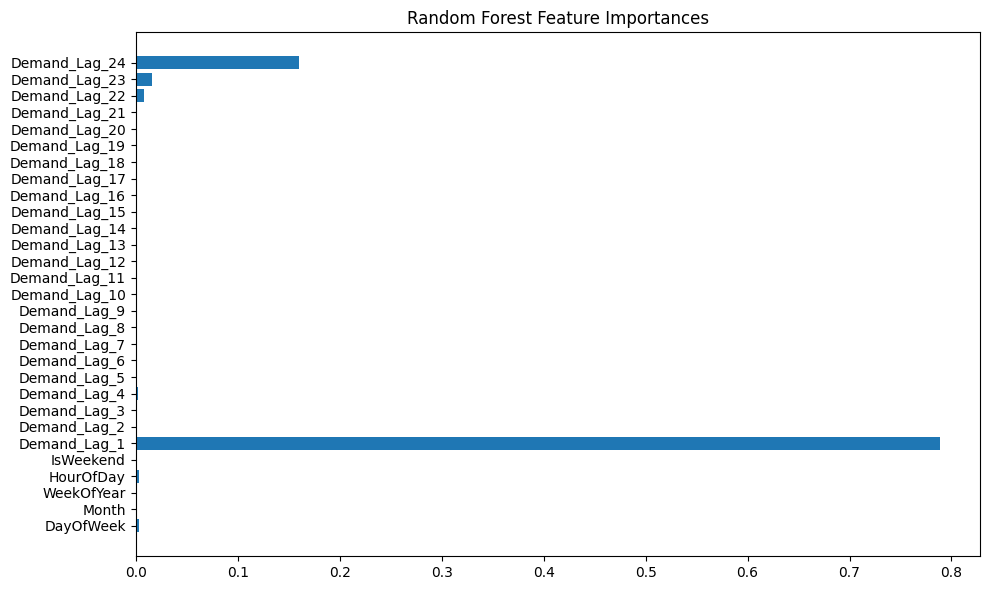

C:\Users\Sanjeev\AppData\Local\Temp\ipykernel_13332\3302142601.py:91: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_dates = pd.date_range(start='2023-01-01', end='2023-12-31 23:00', freq='H')
c:\Users\Sanjeev\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\Sanjeev\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\Sanjeev\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\Sanjeev\AppData\Local\Programs\Python\Pyth

📦 Hourly predictions saved to '2023_hourly_predictions.csv'


c:\Users\Sanjeev\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\Sanjeev\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\Sanjeev\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\Sanjeev\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\Sanjeev\AppData\Local\Programs\Python\Python310\lib\site-packag

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# -------------------------------
# Step 1: Load and Clean Data
# -------------------------------

file_path = 'merge-csv.com__685e341ae0fa0.csv'
df = pd.read_csv(file_path, header=None)

# Assign column names
columns = ['Date'] + [f'Hour_{i}' for i in range(1, 25)]
df.columns = columns

# Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.dropna(subset=['Date']).reset_index(drop=True)

# Melt to long format
df_long = df.melt(id_vars='Date', var_name='Hour', value_name='Demand')
df_long['Hour'] = df_long['Hour'].str.replace('Hour_', '').astype(int)
df_long['DateTime'] = df_long['Date'] + pd.to_timedelta(df_long['Hour'], unit='h')
df_long.set_index('DateTime', inplace=True)
df_long = df_long[['Demand']].sort_index()

# Convert to numeric and interpolate missing values
df_long['Demand'] = pd.to_numeric(df_long['Demand'], errors='coerce')
df_long = df_long.interpolate(method='time')

# -------------------------------
# Step 2: Feature Engineering
# -------------------------------

def create_features(data):
    data = data.copy()
    data['DayOfWeek'] = data.index.dayofweek
    data['Month'] = data.index.month
    data['WeekOfYear'] = data.index.isocalendar().week.astype(int)
    data['HourOfDay'] = data.index.hour
    data['IsWeekend'] = (data['DayOfWeek'] >= 5).astype(int)
    return data

def add_lags(data, lags=24):
    df_ = data.copy()
    for lag in range(1, lags+1):
        df_[f'Demand_Lag_{lag}'] = df_['Demand'].shift(lag)
    df_.dropna(inplace=True)
    return df_

df_featured = create_features(df_long)
df_featured = add_lags(df_featured, lags=24)

X = df_featured.drop(columns=['Demand'])
y = df_featured['Demand']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# -------------------------------
# Step 3: Train Model
# -------------------------------

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate model
test_preds = model.predict(X_test)
mape = mean_absolute_percentage_error(y_test, test_preds) * 100
print(f"✅ Model MAPE on test data: {mape:.2f}%")

# -------------------------------
# Step 4: Feature Importance
# -------------------------------

importances = model.feature_importances_
features = X.columns

plt.figure(figsize=(10, 6))
plt.barh(features, importances)
plt.title("Random Forest Feature Importances")
plt.tight_layout()
plt.show()

# -------------------------------
# Step 5: Forecast 2023 Hourly Demand
# -------------------------------

future_dates = pd.date_range(start='2023-01-01', end='2023-12-31 23:00', freq='H')
current_data = X.iloc[-1].copy()
predictions = []

for date in future_dates:
    # Update date-based features
    current_data['HourOfDay'] = date.hour
    current_data['DayOfWeek'] = date.dayofweek
    current_data['Month'] = date.month
    current_data['WeekOfYear'] = date.isocalendar()[1]
    current_data['IsWeekend'] = int(date.dayofweek >= 5)

    # Predict
    X_input = current_data.values.reshape(1, -1)
    pred = model.predict(X_input)[0]
    predictions.append(pred)

    # Update lag features
    for lag in range(24, 0, -1):
        if lag == 1:
            current_data[f'Demand_Lag_{lag}'] = pred
        else:
            current_data[f'Demand_Lag_{lag}'] = current_data[f'Demand_Lag_{lag - 1}']

# -------------------------------
# Step 6: Save Predictions
# -------------------------------

pred_df = pd.DataFrame({
    'DateTime': future_dates,
    'Predicted_Demand': predictions
})

pred_df.to_csv('2023_hourly_predictions2.csv', index=False)
print("📦 Hourly predictions saved to '2023_hourly_predictions.csv'")


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from datetime import timedelta

# -------------------------------
# Step 1: Load and Clean Data
# -------------------------------

# Load CSV file
file_path = 'merge-csv.com__685e341ae0fa0.csv'
df = pd.read_csv(file_path, header=None)

# Assign column names
columns = ['Date'] + [f'Hour_{i}' for i in range(1, 25)]
df.columns = columns

# Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.dropna(subset=['Date']).reset_index(drop=True)

# Melt to long format
df_long = df.melt(id_vars='Date', var_name='Hour', value_name='Demand')
df_long['Hour'] = df_long['Hour'].str.replace('Hour_', '').astype(int)
df_long['DateTime'] = df_long['Date'] + pd.to_timedelta(df_long['Hour'], unit='h')
df_long.set_index('DateTime', inplace=True)
df_long = df_long[['Demand']].sort_index()

# Convert to numeric and interpolate missing values
df_long['Demand'] = pd.to_numeric(df_long['Demand'], errors='coerce')
df_long = df_long.interpolate(method='time')

# Normalize the data
scaler = MinMaxScaler()
df_long['Demand_Scaled'] = scaler.fit_transform(df_long[['Demand']])

# -------------------------------
# Step 2: Create Sequences for LSTM
# -------------------------------

def create_sequences(data, seq_length=24):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 24
data_scaled = df_long['Demand_Scaled'].values
X, y = create_sequences(data_scaled, SEQ_LENGTH)

# Split training data
split = int(len(X) * 0.9)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Reshape input to [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# -------------------------------
# Step 3: Build LSTM Model Using Keras
# -------------------------------

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(SEQ_LENGTH, 1)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# -------------------------------
# Step 4: Predict 2023 Hourly Demand
# -------------------------------

# Generate date range for 2023
future_dates = pd.date_range(start='2023-01-01', end='2023-12-31 23:00', freq='H')

# Start with last known sequence from historical data
current_sequence = data_scaled[-SEQ_LENGTH:].copy()
predictions = []

for _ in future_dates:
    # Prepare input
    X_input = current_sequence.reshape((1, SEQ_LENGTH, 1))
    
    # Make prediction
    pred = model.predict(X_input, verbose=0)[0][0]
    predictions.append(pred)
    
    # Update sequence for next prediction
    current_sequence = np.roll(current_sequence, shift=-1)
    current_sequence[-1] = pred

# Inverse transform predictions
pred_actual = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()

# -------------------------------
# Step 5: Save Predictions to CSV
# -------------------------------

pred_df = pd.DataFrame({
    'DateTime': future_dates,
    'Predicted_Demand': pred_actual
})

pred_df.to_csv('2023_lstm_predictions.csv', index=False)
print("✅ Predictions saved to '2023_lstm_predictions.csv'")

c:\Users\Sanjeev\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
493/493 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0367 - val_loss: 0.0042
Epoch 2/20
493/493 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0077 - val_loss: 0.0029
Epoch 3/20
493/493 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0048 - val_loss: 0.0021
Epoch 4/20
493/493 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0040 - val_loss: 0.0024
Epoch 5/20
493/493 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0037 - val_loss: 0.0023
Epoch 6/20
493/493 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0031 - val_loss: 0.0017
Epoch 7/20
493/493 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0029 - val_loss: 0.0016
Epoch 8/20
493/493 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0026 - val_loss: 0.0017
Epoch 9/20
493/493 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0025 - val_loss: 0.0019
Epoch 10/20
493/493 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0024 - val_loss: 0.0014
Epoch 11/20
493/493 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0023 - val_loss: 0.0013
Epoch 12/20
493/493 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms

C:\Users\Sanjeev\AppData\Local\Temp\ipykernel_13332\1505833022.py:84: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_dates = pd.date_range(start='2023-01-01', end='2023-12-31 23:00', freq='H')


✅ Predictions saved to '2023_lstm_predictions.csv'


C:\Users\Sanjeev\AppData\Local\Temp\ipykernel_13332\3136882391.py:48: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_profiles = df_daily['Demand'].resample('M').apply(list)


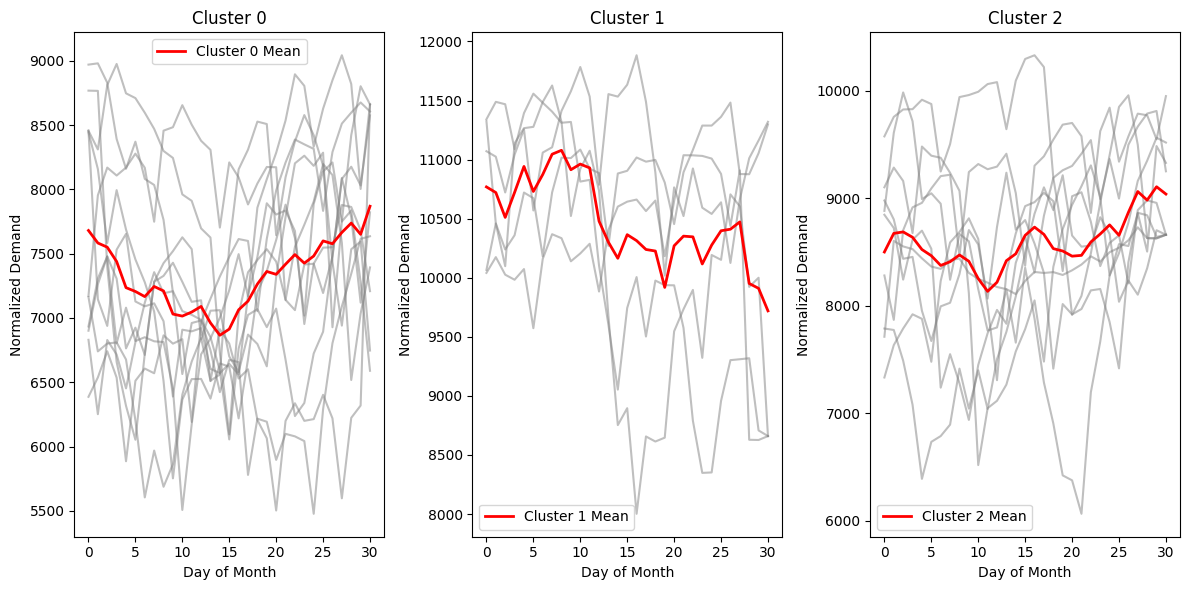


Monthly Cluster Assignment:

Cluster 0:
['2021-05', '2021-06', '2021-07', '2021-08', '2021-10', '2021-11', '2021-12', '2022-07', '2022-08', '2022-09', '2022-10']

Cluster 1:
['2021-03', '2021-04', '2022-02', '2022-03', '2022-04']

Cluster 2:
['2021-01', '2021-02', '2021-09', '2022-01', '2022-05', '2022-06', '2022-11', '2022-12', '2023-01']


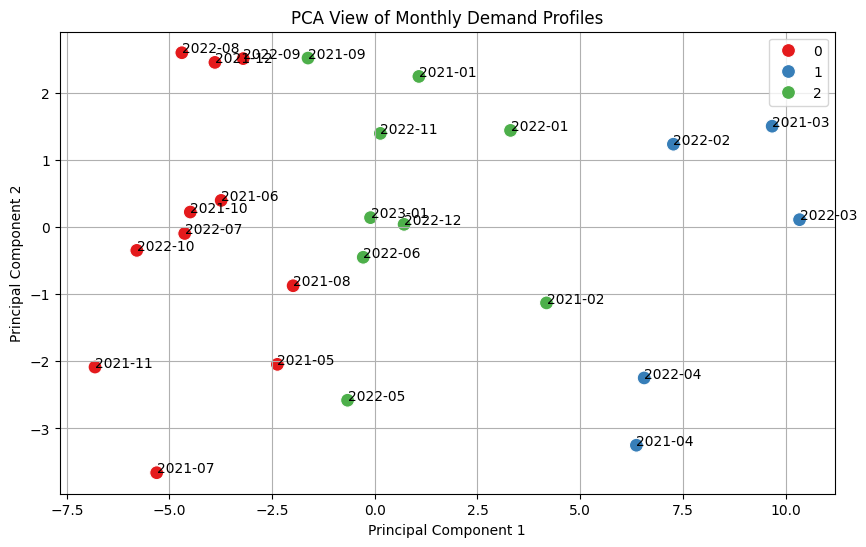

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# -------------------------------
# Step 1: Load and Preprocess Data
# -------------------------------

# Load CSV file
file_path = 'merge-csv.com__685e341ae0fa0.csv'
df = pd.read_csv(file_path, header=None)

# Assign column names
columns = ['Date'] + [f'Hour_{i}' for i in range(1, 25)]
df.columns = columns

# Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.dropna(subset=['Date']).reset_index(drop=True)

# Melt to long format
df_long = df.melt(id_vars='Date', var_name='Hour', value_name='Demand')
df_long['Hour'] = df_long['Hour'].str.replace('Hour_', '').astype(int)
df_long['DateTime'] = df_long['Date'] + pd.to_timedelta(df_long['Hour'], unit='h')
df_long.set_index('DateTime', inplace=True)
df_long = df_long[['Demand']].sort_index()

# Convert to numeric and interpolate missing values
df_long['Demand'] = pd.to_numeric(df_long['Demand'], errors='coerce')
df_long = df_long.interpolate(method='time')

# Resample to daily average demand
df_daily = df_long.resample('D').mean()

# Add month and season info
df_daily['Month'] = df_daily.index.month
df_daily['Season'] = df_daily['Month'] % 12 // 3 + 1  # Simple season mapping: 1=Winter, 2=Spring, 3=Summer, 4=Fall

# -------------------------------
# Step 2: Segment by Month for Clustering
# -------------------------------

# Group by month and create time series per month
monthly_profiles = df_daily['Demand'].resample('M').apply(list)

# Pad lists to same length (some months have 30 days, some 31)
max_len = max(len(profile) for profile in monthly_profiles)
monthly_profiles_padded = pd.DataFrame({
    month: np.pad(profile, (0, max_len - len(profile)), 'constant', constant_values=np.nan)
    for month, profile in monthly_profiles.items()
}).T

# Fill NA with mean demand
monthly_profiles_padded.fillna(monthly_profiles_padded.mean(), inplace=True)

# Normalize profiles
scaler = StandardScaler()
monthly_scaled = scaler.fit_transform(monthly_profiles_padded)

# -------------------------------
# Step 3: Apply KMeans Clustering
# -------------------------------

# Choose number of clusters (k=3 as per the paper)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(monthly_scaled)

# Add cluster labels back to DataFrame
monthly_profiles_padded['Cluster'] = clusters

# -------------------------------
# Step 4: Analyze and Visualize Clusters
# -------------------------------

# Plot each cluster
plt.figure(figsize=(12, 6))
for cluster_id in range(3):
    subset = monthly_profiles_padded[monthly_profiles_padded['Cluster'] == cluster_id]
    plt.subplot(1, 3, cluster_id + 1)
    for _, row in subset.iterrows():
        plt.plot(row[:-1], color='gray', alpha=0.5)
    plt.plot(subset.iloc[:, :-1].mean(axis=0), color='red', linewidth=2, label=f'Cluster {cluster_id} Mean')
    plt.title(f'Cluster {cluster_id}')
    plt.xlabel('Day of Month')
    plt.ylabel('Normalized Demand')
    plt.legend()
plt.tight_layout()
plt.show()

# Print which months are in which clusters
monthly_profiles_padded['Month_Name'] = monthly_profiles_padded.index.strftime('%Y-%m')
print("\nMonthly Cluster Assignment:")
for cluster_id in range(3):
    print(f"\nCluster {cluster_id}:")
    print(monthly_profiles_padded[monthly_profiles_padded['Cluster'] == cluster_id]['Month_Name'].tolist())

# Optional: PCA Visualization
pca = PCA(n_components=2)
reduced = pca.fit_transform(monthly_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=reduced[:, 0], y=reduced[:, 1], hue=clusters, palette='Set1', s=100)
for i, txt in enumerate(monthly_profiles_padded.index.strftime('%Y-%m')):
    plt.annotate(txt, (reduced[i, 0], reduced[i, 1]))
plt.title("PCA View of Monthly Demand Profiles")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()

LSTMModel(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)
Epoch 10, Loss: 0.00028
Epoch 20, Loss: 0.00101
Epoch 30, Loss: 0.00027
Epoch 40, Loss: 0.00108
Epoch 50, Loss: 0.00016


C:\Users\Sanjeev\AppData\Local\Temp\ipykernel_13332\332247169.py:117: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_dates = pd.date_range(start='2023-01-01', end='2023-12-31 23:00', freq='H')


✅ Predictions saved to '2023_lstm_original_predictions.csv'


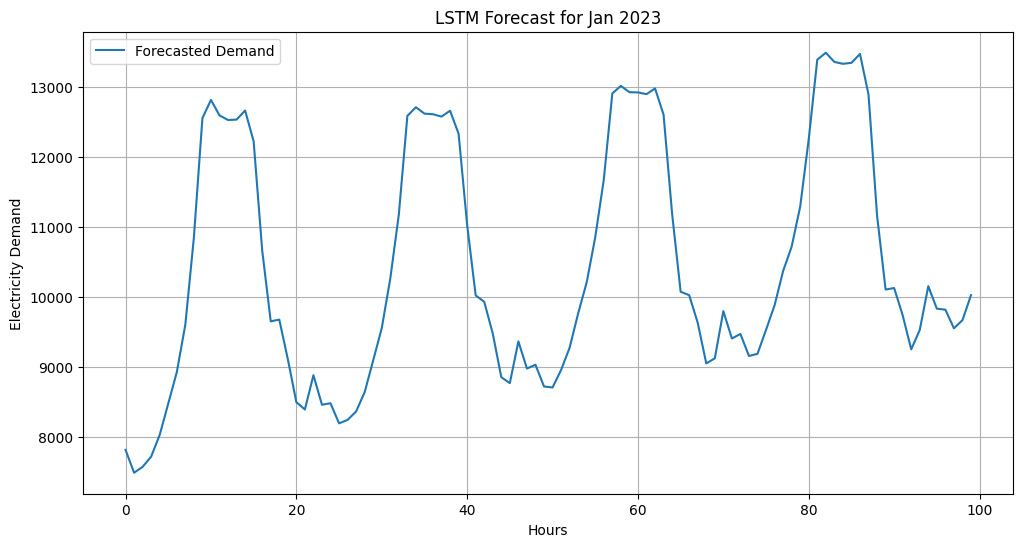

In [9]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
import matplotlib.pyplot as plt

# -------------------------------
# Step 1: Load and Preprocess Data
# -------------------------------

# Load CSV file
file_path = 'merge-csv.com__685e341ae0fa0.csv'
df = pd.read_csv(file_path, header=None)

# Assign column names
columns = ['Date'] + [f'Hour_{i}' for i in range(1, 25)]
df.columns = columns

# Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.dropna(subset=['Date']).reset_index(drop=True)

# Melt to long format
df_long = df.melt(id_vars='Date', var_name='Hour', value_name='Demand')
df_long['Hour'] = df_long['Hour'].str.replace('Hour_', '').astype(int)
df_long['DateTime'] = pd.to_datetime(df_long['Date']) + pd.to_timedelta(df_long['Hour'], unit='h')
df_long.set_index('DateTime', inplace=True)
df_long = df_long[['Demand']].sort_index()

# Convert to numeric and interpolate missing values
df_long['Demand'] = pd.to_numeric(df_long['Demand'], errors='coerce')
df_long = df_long.interpolate(method='time')

# Normalize the data
scaler = MinMaxScaler()
df_long['Demand_Scaled'] = scaler.fit_transform(df_long[['Demand']])

# -------------------------------
# Step 2: Create Sequences
# -------------------------------

def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 24  # Use past 24 hours to predict next hour
X, y = create_sequences(df_long['Demand_Scaled'].values, SEQ_LENGTH)

# Train-test split
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)  # shape: (samples, timesteps, features)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# -------------------------------
# Step 3: Define LSTM Model
# -------------------------------

class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, output_size=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.linear(out[:, -1, :])  # Take last timestep output
        return out

model = LSTMModel()
print(model)

# -------------------------------
# Step 4: Train the Model
# -------------------------------

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

EPOCHS = 50
BATCH_SIZE = 32

# Convert to DataLoader
from torch.utils.data import TensorDataset, DataLoader
train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

# Training loop
for epoch in range(EPOCHS):
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = criterion(y_pred.squeeze(), y_batch)
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.5f}")

# -------------------------------
# Step 5: Forecast 2023 Hourly Demand
# -------------------------------

# Generate date range for 2023
future_dates = pd.date_range(start='2023-01-01', end='2023-12-31 23:00', freq='H')

# Start with last known sequence from historical data
current_sequence = df_long['Demand_Scaled'].values[-SEQ_LENGTH:].copy()
predictions = []

for _ in future_dates:
    # Prepare input
    X_input = torch.tensor(current_sequence, dtype=torch.float32).unsqueeze(0).unsqueeze(-1)  # shape: (1, seq_len, 1)
    
    # Make prediction
    pred = model(X_input).item()
    predictions.append(pred)
    
    # Update sequence
    current_sequence = np.roll(current_sequence, shift=-1)
    current_sequence[-1] = pred

# Inverse transform predictions
pred_actual = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()

# -------------------------------
# Step 6: Save Predictions to CSV
# -------------------------------

# Create DataFrame
pred_df = pd.DataFrame({
    'DateTime': future_dates,
    'Predicted_Demand': pred_actual
})

# Save to CSV
pred_df.to_csv('2023_lstm_original_predictions.csv', index=False)
print("✅ Predictions saved to '2023_lstm_original_predictions.csv'")

# -------------------------------
# Optional: Plot Sample Predictions
# -------------------------------

plt.figure(figsize=(12, 6))
plt.plot(pred_actual[:100], label='Forecasted Demand')
plt.title("LSTM Forecast for Jan 2023")
plt.xlabel("Hours")
plt.ylabel("Electricity Demand")
plt.legend()
plt.grid(True)
plt.show()

In [8]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

# -------------------------------
# Step 1: Load and Preprocess Data
# -------------------------------

# Load CSV file
file_path = 'merge-csv.com__685e341ae0fa0.csv'
df = pd.read_csv(file_path, header=None)

# Assign column names
columns = ['Date'] + [f'Hour_{i}' for i in range(1, 25)]
df.columns = columns

# Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.dropna(subset=['Date']).reset_index(drop=True)

# Melt to long format
df_long = df.melt(id_vars='Date', var_name='Hour', value_name='Demand')
df_long['Hour'] = df_long['Hour'].str.replace('Hour_', '').astype(int)
df_long['DateTime'] = df_long['Date'] + pd.to_timedelta(df_long['Hour'], unit='h')
df_long.set_index('DateTime', inplace=True)
df_long = df_long[['Demand']].sort_index()

# Convert to numeric and interpolate missing values
df_long['Demand'] = pd.to_numeric(df_long['Demand'], errors='coerce')
df_long = df_long.interpolate(method='time')

# Normalize the data
scaler = MinMaxScaler()
df_long['Demand_Scaled'] = scaler.fit_transform(df_long[['Demand']])

# -------------------------------
# Step 2: Create Sequences
# -------------------------------

def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 24  # Use past 24 hours to predict next hour
X, y = create_sequences(df_long['Demand_Scaled'].values, SEQ_LENGTH)

# Train-validation-test split
split_train_val = int(len(X) * 0.8)
split_val_test = int(len(X) * 0.9)
X_train, X_val, X_test = X[:split_train_val], X[split_train_val:split_val_test], X[split_val_test:]
y_train, y_val, y_test = y[:split_train_val], y[split_train_val:split_val_test], y[split_val_test:]

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)  # shape: (samples, timesteps, features)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).unsqueeze(-1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# -------------------------------
# Step 3: Define LSTM Model
# -------------------------------

class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, output_size=1, dropout_rate=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate)
        self.dropout = nn.Dropout(dropout_rate)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out)
        out = self.linear(out[:, -1, :])  # Take last timestep output
        return out

model = LSTMModel()
print(model)

# -------------------------------
# Step 4: Train the Model
# -------------------------------

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

EPOCHS = 50
BATCH_SIZE = 32

# Convert to DataLoader
train_data = TensorDataset(X_train_tensor, y_train_tensor)
val_data = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)

for epoch in range(EPOCHS):
    # Training phase
    model.train()
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = criterion(y_pred.squeeze(), y_batch)
        loss.backward()
        optimizer.step()
    
    # Validation phase
    model.eval()
    val_losses = []
    with torch.no_grad():
        for x_val_batch, y_val_batch in val_loader:
            y_val_pred = model(x_val_batch)
            val_loss = criterion(y_val_pred.squeeze(), y_val_batch)
            val_losses.append(val_loss.item())
    
    avg_val_loss = np.mean(val_losses)
    print(f"Epoch {epoch+1}, Loss: {loss.item():.5f}, Val Loss: {avg_val_loss:.5f}")

# -------------------------------
# Step 5: Forecast 2023 Hourly Demand
# -------------------------------

# Generate date range for 2023
future_dates = pd.date_range(start='2023-01-01', end='2023-12-31 23:00', freq='H')

# Start with last known sequence from historical data
current_sequence = df_long['Demand_Scaled'].values[-SEQ_LENGTH:].copy()
predictions = []

for _ in future_dates:
    # Prepare input
    X_input = torch.tensor(current_sequence, dtype=torch.float32).unsqueeze(0).unsqueeze(-1)  # shape: (1, seq_len, 1)
    
    # Make prediction
    pred = model(X_input).item()
    predictions.append(pred)
    
    # Update sequence
    current_sequence = np.roll(current_sequence, shift=-1)
    current_sequence[-1] = pred

# Inverse transform predictions
pred_actual = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()

# -------------------------------
# Step 6: Save Predictions to CSV
# -------------------------------

# Create DataFrame
pred_df = pd.DataFrame({
    'DateTime': future_dates,
    'Predicted_Demand': pred_actual
})

# Save to CSV
pred_df.to_csv('2023_lstm_original_2_predictions.csv', index=False)
print("✅ Predictions saved to '2023_lstm_original_2_predictions.csv'")

LSTMModel(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)
Epoch 1, Loss: 0.00530, Val Loss: 0.00327
Epoch 2, Loss: 0.00122, Val Loss: 0.00186
Epoch 3, Loss: 0.00489, Val Loss: 0.00128
Epoch 4, Loss: 0.00429, Val Loss: 0.00150
Epoch 5, Loss: 0.00256, Val Loss: 0.00111
Epoch 6, Loss: 0.00242, Val Loss: 0.00096
Epoch 7, Loss: 0.00147, Val Loss: 0.00090
Epoch 8, Loss: 0.00066, Val Loss: 0.00088
Epoch 9, Loss: 0.00199, Val Loss: 0.00087
Epoch 10, Loss: 0.00131, Val Loss: 0.00094
Epoch 11, Loss: 0.00164, Val Loss: 0.00093
Epoch 12, Loss: 0.00098, Val Loss: 0.00114
Epoch 13, Loss: 0.00163, Val Loss: 0.00083
Epoch 14, Loss: 0.00100, Val Loss: 0.00113
Epoch 15, Loss: 0.00075, Val Loss: 0.00089
Epoch 16, Loss: 0.00071, Val Loss: 0.00080
Epoch 17, Loss: 0.00104, Val Loss: 0.00081
Epoch 18, Loss: 0.00085, Val Loss: 0.00078
Epoch 19, Loss: 0.00164, Val Loss: 0.00079
Epoch 2

C:\Users\Sanjeev\AppData\Local\Temp\ipykernel_13332\182498002.py:133: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_dates = pd.date_range(start='2023-01-01', end='2023-12-31 23:00', freq='H')


✅ Predictions saved to '2023_lstm_original_2_predictions.csv'


LSTMModel(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)
Epoch 1, Train Loss: 0.01365, Val Loss: 0.00262
Epoch 2, Train Loss: 0.00386, Val Loss: 0.00296
Epoch 3, Train Loss: 0.00266, Val Loss: 0.00115
Epoch 4, Train Loss: 0.00225, Val Loss: 0.00133
Epoch 5, Train Loss: 0.00206, Val Loss: 0.00095
Epoch 6, Train Loss: 0.00184, Val Loss: 0.00101
Epoch 7, Train Loss: 0.00178, Val Loss: 0.00087
Epoch 8, Train Loss: 0.00173, Val Loss: 0.00140
Epoch 9, Train Loss: 0.00161, Val Loss: 0.00103
Epoch 10, Train Loss: 0.00157, Val Loss: 0.00098
Epoch 11, Train Loss: 0.00152, Val Loss: 0.00085
Epoch 12, Train Loss: 0.00145, Val Loss: 0.00092
Epoch 13, Train Loss: 0.00148, Val Loss: 0.00091
Epoch 14, Train Loss: 0.00139, Val Loss: 0.00111
Epoch 15, Train Loss: 0.00138, Val Loss: 0.00079
Epoch 16, Train Loss: 0.00134, Val Loss: 0.00090
Epoch 17, Train Loss: 0.00134, Val Loss:

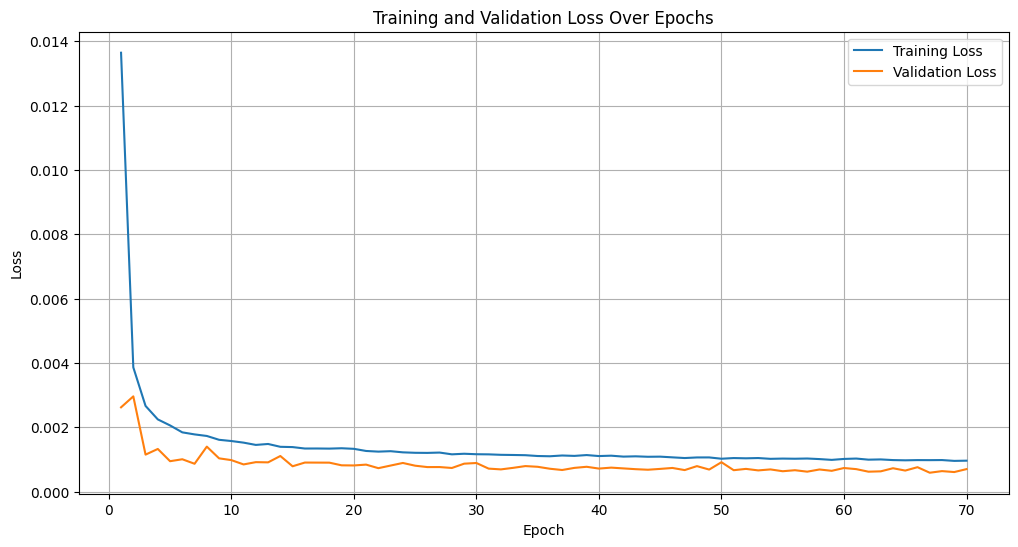

Test MAE: 238.02
Test RMSE: 332.22
Test R² Score: 0.97


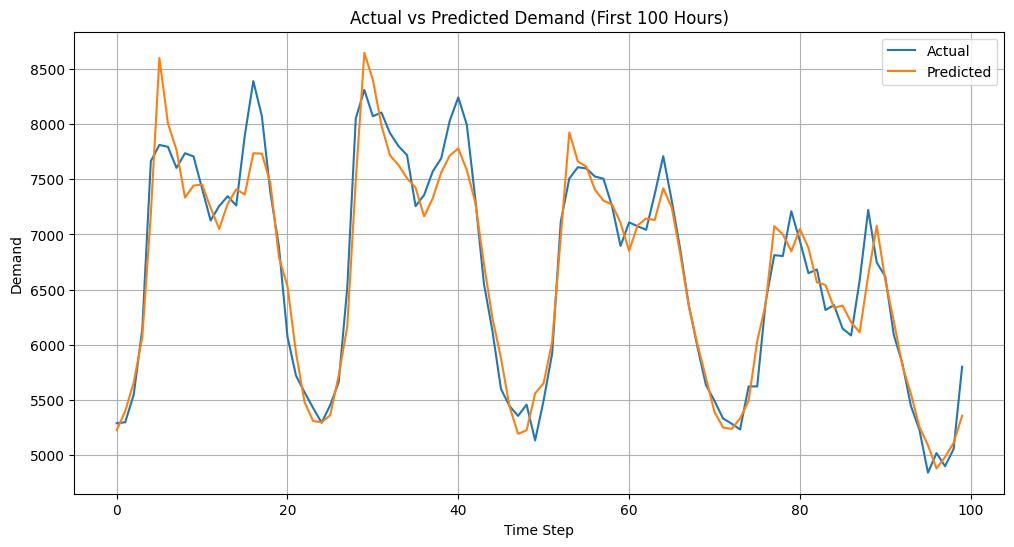

C:\Users\Sanjeev\AppData\Local\Temp\ipykernel_13332\3264883255.py:187: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_dates = pd.date_range(start='2023-01-01', end='2023-12-31 23:00', freq='H')


✅ Predictions saved to '2023_lstm_original_predictions_validated.csv'


In [10]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# -------------------------------
# Step 1: Load and Preprocess Data
# -------------------------------

# Load CSV file
file_path = 'merge-csv.com__685e341ae0fa0.csv'
df = pd.read_csv(file_path, header=None)

# Assign column names
columns = ['Date'] + [f'Hour_{i}' for i in range(1, 25)]
df.columns = columns

# Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.dropna(subset=['Date']).reset_index(drop=True)

# Melt to long format
df_long = df.melt(id_vars='Date', var_name='Hour', value_name='Demand')
df_long['Hour'] = df_long['Hour'].str.replace('Hour_', '').astype(int)
df_long['DateTime'] = df_long['Date'] + pd.to_timedelta(df_long['Hour'], unit='h')
df_long.set_index('DateTime', inplace=True)
df_long = df_long[['Demand']].sort_index()

# Convert to numeric and interpolate missing values
df_long['Demand'] = pd.to_numeric(df_long['Demand'], errors='coerce')
df_long = df_long.interpolate(method='time')

# Normalize the data
scaler = MinMaxScaler()
df_long['Demand_Scaled'] = scaler.fit_transform(df_long[['Demand']])

# -------------------------------
# Step 2: Create Sequences
# -------------------------------

def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 24  # Use past 24 hours to predict next hour
X, y = create_sequences(df_long['Demand_Scaled'].values, SEQ_LENGTH)

# Train-validation-test split
split_train_val = int(len(X) * 0.8)
split_val_test = int(len(X) * 0.9)
X_train, X_val, X_test = X[:split_train_val], X[split_train_val:split_val_test], X[split_val_test:]
y_train, y_val, y_test = y[:split_train_val], y[split_train_val:split_val_test], y[split_val_test:]

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)  # shape: (samples, timesteps, features)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).unsqueeze(-1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# -------------------------------
# Step 3: Define LSTM Model
# -------------------------------

class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, output_size=1, dropout_rate=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate)
        self.dropout = nn.Dropout(dropout_rate)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out)
        out = self.linear(out[:, -1, :])  # Take last timestep output
        return out

model = LSTMModel()
print(model)

# -------------------------------
# Step 4: Train the Model
# -------------------------------

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

EPOCHS = 70  # Extended from 50 to 70 epochs
BATCH_SIZE = 32

# Convert to DataLoader
train_data = TensorDataset(X_train_tensor, y_train_tensor)
val_data = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)

# Track training history
train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    # Training phase
    model.train()
    epoch_loss = 0.0
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = criterion(y_pred.squeeze(), y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x_val_batch, y_val_batch in val_loader:
            y_val_pred = model(x_val_batch)
            val_loss += criterion(y_val_pred.squeeze(), y_val_batch).item()
    
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.5f}, Val Loss: {avg_val_loss:.5f}")

# Plot learning curve
plt.figure(figsize=(12, 6))
plt.plot(range(1, EPOCHS+1), train_losses, label='Training Loss')
plt.plot(range(1, EPOCHS+1), val_losses, label='Validation Loss')
plt.title("Training and Validation Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# -------------------------------
# Step 5: Evaluate on Test Set
# -------------------------------

# Evaluate on test set
model.eval()
with torch.no_grad():
    test_preds = model(X_test_tensor).squeeze().numpy()
    test_preds_actual = scaler.inverse_transform(test_preds.reshape(-1, 1)).flatten()
    y_test_actual = scaler.inverse_transform(y_test_tensor.numpy().reshape(-1, 1)).flatten()

# Calculate metrics
mae = mean_absolute_error(y_test_actual, test_preds_actual)
rmse = np.sqrt(mean_squared_error(y_test_actual, test_preds_actual))
r2 = r2_score(y_test_actual, test_preds_actual)

print(f"Test MAE: {mae:.2f}")
print(f"Test RMSE: {rmse:.2f}")
print(f"Test R² Score: {r2:.2f}")

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual[:100], label='Actual')
plt.plot(test_preds_actual[:100], label='Predicted')
plt.title("Actual vs Predicted Demand (First 100 Hours)")
plt.xlabel("Time Step")
plt.ylabel("Demand")
plt.legend()
plt.grid(True)
plt.show()

# -------------------------------
# Step 6: Forecast 2023 Hourly Demand
# -------------------------------

# Generate date range for 2023
future_dates = pd.date_range(start='2023-01-01', end='2023-12-31 23:00', freq='H')

# Start with last known sequence from historical data
current_sequence = df_long['Demand_Scaled'].values[-SEQ_LENGTH:].copy()
predictions = []

for _ in future_dates:
    # Prepare input
    X_input = torch.tensor(current_sequence, dtype=torch.float32).unsqueeze(0).unsqueeze(-1)  # shape: (1, seq_len, 1)
    
    # Make prediction
    pred = model(X_input).item()
    predictions.append(pred)
    
    # Update sequence
    current_sequence = np.roll(current_sequence, shift=-1)
    current_sequence[-1] = pred

# Inverse transform predictions
pred_actual = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()

# -------------------------------
# Step 7: Save Predictions to CSV
# -------------------------------

# Create DataFrame
pred_df = pd.DataFrame({
    'DateTime': future_dates,
    'Predicted_Demand': pred_actual
})

# Save to CSV
pred_df.to_csv('2023_lstm_original_predictions_validated.csv', index=False)
print("✅ Predictions saved to '2023_lstm_original_predictions_validated.csv'")

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# -------------------------------
# Step 1: Load and Preprocess Data
# -------------------------------

file_path = 'merge-csv.com__685e341ae0fa0.csv'
df = pd.read_csv(file_path, header=None)

columns = ['Date'] + [f'Hour_{i}' for i in range(1, 25)]
df.columns = columns

df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.dropna(subset=['Date']).reset_index(drop=True)

df_long = df.melt(id_vars='Date', var_name='Hour', value_name='Demand')
df_long['Hour'] = df_long['Hour'].str.replace('Hour_', '').astype(int)
df_long['DateTime'] = df_long['Date'] + pd.to_timedelta(df_long['Hour'] - 1, unit='h')
df_long.set_index('DateTime', inplace=True)
df_long = df_long[['Demand']].sort_index()

df_long['Demand'] = pd.to_numeric(df_long['Demand'], errors='coerce')
df_long = df_long.interpolate(method='time')

scaler = MinMaxScaler()
df_long['Demand_Scaled'] = scaler.fit_transform(df_long[['Demand']])

# -------------------------------
# Step 2: Create Sequences (MIMO Version)
# -------------------------------

def create_sequences_mimo(data, seq_length=24, pred_steps=6):
    xs, ys = [], []
    for i in range(len(data) - seq_length - pred_steps + 1):
        x = data[i:i+seq_length]
        y = data[i+seq_length:i+seq_length+pred_steps]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 24
PRED_STEPS = 6

X, y = create_sequences_mimo(df_long['Demand_Scaled'].values, SEQ_LENGTH, PRED_STEPS)

split_train_val = int(len(X) * 0.8)
split_val_test = int(len(X) * 0.9)

X_train, X_val, X_test = X[:split_train_val], X[split_train_val:split_val_test], X[split_val_test:]
y_train, y_val, y_test = y[:split_train_val], y[split_train_val:split_val_test], y[split_val_test:]

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).unsqueeze(-1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)

y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# -------------------------------
# Step 3: Define LSTM Model (MIMO Strategy)
# -------------------------------

class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, output_size=6, dropout_rate=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate)
        self.dropout = nn.Dropout(dropout_rate)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out)
        out = self.linear(out[:, -1, :])
        return out

model = LSTMModel(output_size=PRED_STEPS)
print(model)

# -------------------------------
# Step 4: Train the Model (with Validation)
# -------------------------------

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

EPOCHS = 70
BATCH_SIZE = 32

train_data = TensorDataset(X_train_tensor, y_train_tensor)
val_data = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)

train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0.0
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x_val_batch, y_val_batch in val_loader:
            y_val_pred = model(x_val_batch)
            val_loss += criterion(y_val_pred, y_val_batch).item()
    
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.5f}, Val Loss: {avg_val_loss:.5f}")

plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# -------------------------------
# Step 5: Evaluate on Test Set
# -------------------------------

model.eval()
with torch.no_grad():
    test_preds = model(X_test_tensor).numpy()

test_preds_actual = scaler.inverse_transform(test_preds)
y_test_actual = scaler.inverse_transform(y_test_tensor.numpy())

test_preds_flat = test_preds_actual.flatten()
y_test_flat = y_test_actual.flatten()

mae = mean_absolute_error(y_test_flat, test_preds_flat)
rmse = np.sqrt(mean_squared_error(y_test_flat, test_preds_flat))
r2 = r2_score(y_test_flat, test_preds_flat)

print(f"Test MAE: {mae:.2f}")
print(f"Test RMSE: {rmse:.2f}")
print(f"Test R² Score: {r2:.2f}")

plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(5, 1, i+1)
    plt.plot(y_test_actual[i], label='Actual')
    plt.plot(test_preds_actual[i], label='Predicted')
    plt.title(f"Sample {i+1}")
    plt.legend()
plt.tight_layout()
plt.show()

# -------------------------------
# ✅ Step 6: Fixed MIMO Forecast for 2023
# -------------------------------

future_dates = pd.date_range(start='2023-01-01', end='2023-12-31 23:00', freq='H')
current_sequence = df_long['Demand_Scaled'].values[-SEQ_LENGTH:].copy()
predictions = []
predicted_timestamps = []

i = 0
while i < len(future_dates):
    X_input = torch.tensor(current_sequence, dtype=torch.float32).unsqueeze(0).unsqueeze(-1)
    with torch.no_grad():
        pred_scaled = model(X_input).squeeze().numpy()

    predictions.extend(pred_scaled)
    predicted_timestamps.extend(future_dates[i:i+PRED_STEPS])

    for p in pred_scaled:
        current_sequence = np.roll(current_sequence, -1)
        current_sequence[-1] = p

    i += PRED_STEPS

pred_actual = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()

pred_df = pd.DataFrame({
    'DateTime': predicted_timestamps,
    'Predicted_Demand': pred_actual
})

pred_df.to_csv('2023_lstm_mimo_predictions.csv', index=False)
print("✅ Predictions saved to '2023_lstm_mimo_predictions.csv'")


LSTMModel(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear): Linear(in_features=64, out_features=6, bias=True)
)
Epoch 1, Train Loss: 0.02259, Val Loss: 0.00889
Epoch 2, Train Loss: 0.00679, Val Loss: 0.00392
Epoch 3, Train Loss: 0.00515, Val Loss: 0.00323
Epoch 4, Train Loss: 0.00460, Val Loss: 0.00338
Epoch 5, Train Loss: 0.00435, Val Loss: 0.00348
Epoch 6, Train Loss: 0.00417, Val Loss: 0.00325
Epoch 7, Train Loss: 0.00383, Val Loss: 0.00293
Epoch 8, Train Loss: 0.00369, Val Loss: 0.00264
Epoch 9, Train Loss: 0.00351, Val Loss: 0.00291
Epoch 10, Train Loss: 0.00334, Val Loss: 0.00329
Epoch 11, Train Loss: 0.00313, Val Loss: 0.00226
Epoch 12, Train Loss: 0.00299, Val Loss: 0.00214
Epoch 13, Train Loss: 0.00289, Val Loss: 0.00239
Epoch 14, Train Loss: 0.00274, Val Loss: 0.00174
Epoch 15, Train Loss: 0.00261, Val Loss: 0.00170
Epoch 16, Train Loss: 0.00255, Val Loss: 0.00182
Epoch 17, Train Loss: 0.00246, Val Loss: